Описание задания
А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

Описание колонок
experimentVariant – вариант эксперимента
version – версия приложения
purchase – факт п
окупки
Задача
Запустите A/A-тест
Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы был
о меньше.
Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)
Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста
💡 Ответ: как найти причины поломки?
Вам доступна версия мобильного приложения (МП) каждого пользователя. Эту полезную информацию можно использовать для исследования проблемы:

Посчитайте конверсию (коэффициент покупок), группируя по варианту и версии МП. Возможно уже станет ясно где именно причины поломки
Посчитайте pvalue для каждой версии МП
Найдите версии, где pvalue < 0.05
Исключите версию с pvalue < 0.05 из основного датафрейма
Повторно запустите расчет FPR через A/A. Теперь FPR < альфа
Вы нашли поломку

In [254]:
import pandas as pd
import numpy as np
from scipy import stats
import random

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [17]:
data = pd.read_csv('hw_aa.csv', sep=';')
del data['Unnamed: 0']
data

,uid,experimentVariant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...
127013,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127014,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127015,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127016,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127018 entries, 0 to 127017
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   uid                127018 non-null  object
 1   experimentVariant  127018 non-null  int64 
 2   version            127018 non-null  object
 3   purchase           127018 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.9+ MB


In [23]:
data.nunique()

uid                  127018
experimentVariant         2
version                   4
purchase                  2
dtype: int64

In [31]:
data_var0 = data[data['experimentVariant'] == 0]
data_var0.shape

(63102, 4)

In [33]:
data_var1 = data[data['experimentVariant'] == 1]
data_var1.shape

(63916, 4)

In [51]:
stats.ttest_ind(data_var0.purchase, data_var1.purchase)

TtestResult(statistic=-27.148363159364195, pvalue=7.701996608732486e-162, df=127016.0)

In [104]:
# Запуск симуляций A/A теста
p_val_res = []

In [106]:
for i in range(1000):
    var0_sample = data_var0.sample(n=1000, replace=False)
    var1_sample = data_var1.sample(n=1000, replace=False)

    res = stats.ttest_ind(var0_sample.purchase, var1_sample.purchase)[1]
    p_val_res.append(res)

In [108]:
FPR = sum(np.array(p_val_res)<0.05)/1000
FPR

0.935

FPR (False Positive Rate) в контексте A/A-тестирования — метрика качества, которая показывает долю случаев, ошибочно классифицированных как положительные - np.array(p_val_res)<0.05 создаст массив из отметок выполнения условий ложноположительных случаев. FPR > 0.05, т.е. доля ложноположительных оценок (доля симуляций, в которых был получен p < 0.05) составляет больше 5%, причем значительно больше. Таким образом, в подавляющем большинстве случаев мы получаем статистически значимые различия между двумя группами, которых на самом деле быть не должно. Значит, что-то пошло не так, и необходимо искать причину поломки.

ИЩЕМ ПРИЧИНУ СБОЯ РАБОТЫ СИСТЕМЫ СПЛИТОВАНИЯ

In [144]:
Data_care = data.groupby(['experimentVariant', 'version'], as_index=False).agg({'purchase': 'sum', 'uid': 'count'})
Data_care['conversion'] = Data_care['purchase'] / Data_care['uid']
Data_care

,experimentVariant,version,purchase,uid,conversion
0,0,v2.8.0,41,41283,0.000993
1,0,v2.9.0,890,11921,0.074658
2,0,v3.7.4.0,252,4204,0.059943
3,0,v3.8.0.0,328,5694,0.057604
4,1,v2.8.0,1895,41552,0.045606
5,1,v2.9.0,858,12033,0.071304
6,1,v3.7.4.0,266,4221,0.063018
7,1,v3.8.0.0,384,6110,0.062848


In [ ]:
Посчитаем pvalue для каждой версии приложения, исключим неподошедшие

In [224]:
versions = list(Data_care.version.unique())
data_0 = data[data['experimentVariant'] == 0]
data_1 = data[data['experimentVariant'] == 1]
for v in versions:
    Data_var0 = data_0[data_0['version'] == v]['purchase']
    Data_var1 = data_1[data_1['version'] == v]['purchase']
    p_val_res = []
   
    for i in range(1000):
        
        var0_sample = Data_var0.sample(round(0.75 * min(len(Data_var0), len(Data_var1))), replace=False)
        var1_sample = Data_var1.sample(round(0.75 * min(len(Data_var0), len(Data_var1))), replace=False)

        res = stats.ttest_ind(var0_sample, var1_sample)[1]
        p_val_res.append(res)
    FPR = sum(np.array(p_val_res)<0.05)/1000
    print(f'Для версии {v} FPR = {FPR}')

Для версии v2.8.0 FPR = 1.0
Для версии v2.9.0 FPR = 0.01
Для версии v3.7.4.0 FPR = 0.003
Для версии v3.8.0.0 FPR = 0.049


Группы в версии v2.8.0 разделены неравномерно, на что указывают коверсии, различиающиеся на несколько порядков и полученное значение FPR,
с остальными версиями все нормально - доля ложноположительных оценок низкая.

In [ ]:
ПРОВОЕДЕМ А-А ТЕСТ ДЛЯ ОСТАЛЬНЫХ ВЕРСИЙ И ПОСТРОИМ ГИСТРОГРАММУ ПОЛУЧЕННЫХ РЕЗУЛЬТАТОВ ВЕРОЯТНОСТЕЙ на значимость различий ПО НАШЕЙ СИМУЛЦИИ

In [300]:
p_val_res = []
data = data[data['version'] != 'v2.8.0']
data_0 = data[data['experimentVariant'] == 0]
data_1 = data[data['experimentVariant'] == 1]
for i in range(1000):
    var0_sample = data_0.sample(n=1000, replace=False)
    var1_sample = data_1.sample(n=1000, replace=False)

    res = stats.ttest_ind(var0_sample.purchase, var1_sample.purchase)[1]
    p_val_res.append(res)
FPR = sum(np.array(p_val_res)<0.05)/1000    

In [302]:
f'FPR = {FPR}'

'FPR = 0.045'

Значение на границе допустимого, не идеально. Но мы Можем точно сказать, что основная проблема была в исключенной версии.

Text(0.5, 1.0, 'График распределения p-value')

<Figure size 640x480 with 0 Axes>

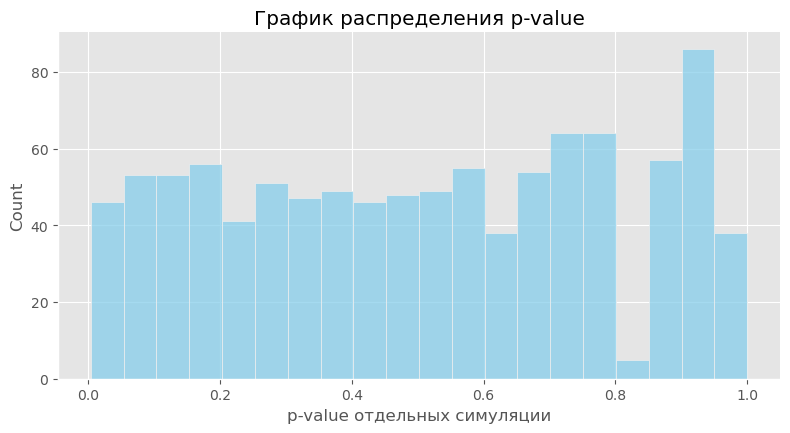

In [304]:
mpl.style.use('ggplot')
plt.figure( facecolor='#A9A9A9')
sns.displot(p_val_res, color='skyblue', bins=20, height=4, aspect=2)
plt.xlabel('p-value отдельных симуляции')
plt.title('График распределения p-value')